# Pneumonia Classifier

## Importing Required Libraries

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import pickle


## Data Preprocessing

In [27]:
def load_data(healthy_path, pneumonia_path):
    images = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.png']

    # Load healthy images
    for img in os.listdir('C:\\Users\\hp\\Desktop\\Data Analysis\\Project 2\\Dataset\\healthy chest x ray images'):
        if any(img.lower().endswith(ext) for ext in valid_extensions):
            try:
                img_array = cv2.imread(os.path.join('C:\\Users\\hp\\Desktop\\Data Analysis\\Project 2\\Dataset\\healthy chest x ray images', img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (150, 150))
                images.append(resized_img)
                labels.append(0)  # Label 0 for healthy
            except Exception as e:
                print(f"Failed to process {img}: {e}")

    # Load pneumonia images
    for img in os.listdir('C:\\Users\\hp\\Desktop\\Data Analysis\\Project 2\\Dataset\\pneumonia x ray images'):
        if any(img.lower().endswith(ext) for ext in valid_extensions):
            try:
                img_array = cv2.imread(os.path.join('C:\\Users\\hp\\Desktop\\Data Analysis\\Project 2\\Dataset\\pneumonia x ray images', img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (150, 150))
                images.append(resized_img)
                labels.append(1)  # Label 1 for pneumonia
            except Exception as e:
                print(f"Failed to process {img}: {e}")

    return np.array(images), np.array(labels)

healthy_path = r'C:\\Users\\hp\\Desktop\\Data Analysis\\Project 2\\Dataset\\healthy chest x ray images'
pneumonia_path = r'C:\\Users\\hp\\Desktop\\Data Analysis\\Project 2\\Dataset\\pneumonia x ray images'

images, labels = load_data(healthy_path, pneumonia_path)

# Normalize the images
images = images / 255.0

## Feature Extraction With PCA

In [28]:
# Flatten the images
n_samples, h, w = images.shape
images_flat = images.reshape(n_samples, h * w)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95, random_state=42)
images_pca = pca.fit_transform(images_flat)

print(f"Original shape: {images_flat.shape}")
print(f"Reduced shape: {images_pca.shape}")


Original shape: (88, 22500)
Reduced shape: (88, 36)


## Building Random Forest Classifier

In [29]:
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model after tuning
best_rf_model = grid_search.best_estimator_

# Train the best model
best_rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

## Adding Prediction Functionality

In [35]:
# Load the trained model
model = joblib.load(joblib_filename)

# Function to preprocess and predict pneumonia from a new image
def predict_pneumonia(model, pca):
    img_path = input("Please enter the full path to the chest X-ray image: ")

    try:
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
        if img_array is None:
            raise ValueError("Image not found or invalid image format.")
        
        resized_img = cv2.resize(img_array, (150, 150))  # Resize to match the training input size
        normalized_img = resized_img / 255.0  # Normalize the image
        flattened_img = normalized_img.flatten().reshape(1, -1)  # Flatten and reshape for model input

        # Apply PCA to the new image
        img_pca = pca.transform(flattened_img)

        # Make a prediction
        prediction = model.predict(img_pca)

        # Interpret the prediction
        if prediction[0] == 0:
            return "Healthy (No Pneumonia)"
        else:
            return "Pneumonia"
    except Exception as e:
        return f"Error: {e}"

# Example usage
result = predict_pneumonia(model, pca)
print(f"The model predicts: {result}")


Please enter the full path to the chest X-ray image: C:\Users\hp\Desktop\Data Analysis\Project 2\Dataset\healthy chest x ray images\chest-xray-260nw-471542198.jpg
The model predicts: Healthy (No Pneumonia)


## Model Evaluation

In [31]:
y_pred = best_rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8333333333333334
Confusion Matrix:
 [[8 0]
 [3 7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.70      0.82        10

    accuracy                           0.83        18
   macro avg       0.86      0.85      0.83        18
weighted avg       0.88      0.83      0.83        18



## Saving the model with joblib and pickle

In [32]:
# Save the model using joblib
joblib_filename = 'pneumonia_detection_rf_model_joblib.pkl'
joblib.dump(best_rf_model, joblib_filename)

# Save the model using pickle
pickle_filename = 'pneumonia_detection_rf_model_pickle.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(best_rf_model, file)


## Loading the model

In [33]:
# Load the model using joblib
loaded_model_joblib = joblib.load(joblib_filename)
y_loaded_pred_joblib = loaded_model_joblib.predict(X_test)
print("Joblib Model Accuracy:", accuracy_score(y_test, y_loaded_pred_joblib))

# Load the model using pickle
with open(pickle_filename, 'rb') as file:
    loaded_model_pickle = pickle.load(file)
y_loaded_pred_pickle = loaded_model_pickle.predict(X_test)
print("Pickle Model Accuracy:", accuracy_score(y_test, y_loaded_pred_pickle))


Joblib Model Accuracy: 0.8333333333333334
Pickle Model Accuracy: 0.8333333333333334


## Vizualizing the results

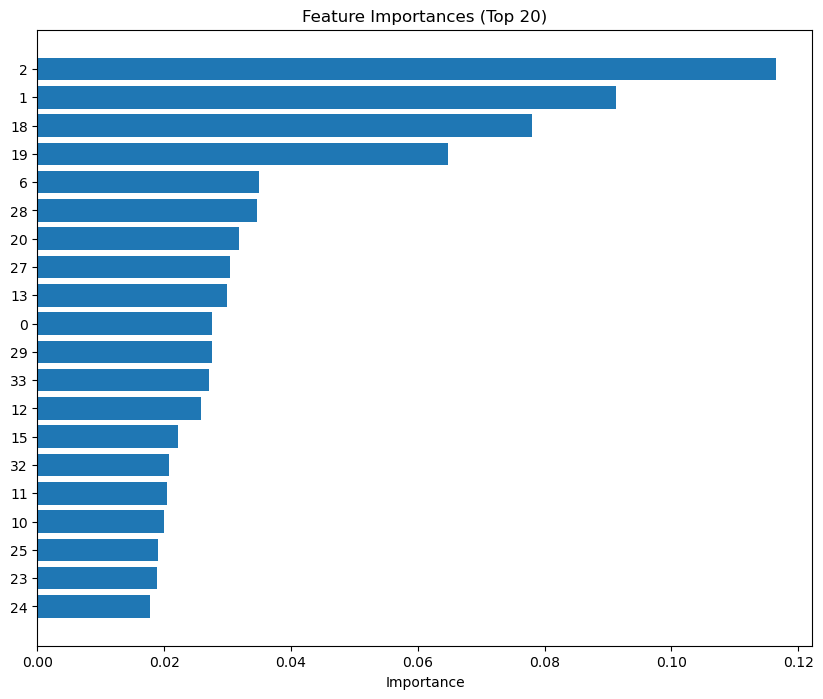

In [34]:
# Plot feature importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 features

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Top 20)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), indices)
plt.xlabel("Importance")
plt.show()
